# DNN for single dot charge learning

In [38]:
import numpy as np
import os
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import time

In [9]:
file_list = glob.glob("/Users/sandesh/data/single_dot_traces/*.npy")
print("Number of files",len(file_list))
data_list = [np.load(f).item() for f in file_list]
print("Data keys",data_list[0].keys())

Number of files 1009
Data keys dict_keys(['V_gate', 'physics', 'gates', 'I', 'charge'])


In [25]:
# load the data
V_gate = data_list[0]['V_gate']
inp_array = np.array([x['I'] for x in data_list])
out_array = np.array([x['charge'] for x in data_list])

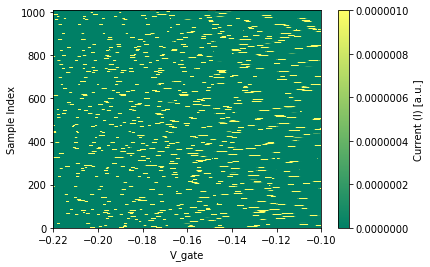

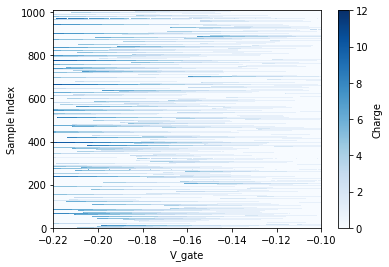

In [26]:
# see the current and charge data for the entire dataset
# note that this is expensive for large datasets

XX,YY = np.meshgrid(V_gate,np.arange(len(data_list)))

plt.figure(1)
plt.pcolor(XX,YY,inp_array,cmap="summer",vmax=1e-6)
plt.xlabel('V_gate')
plt.ylabel('Sample Index')
cbar = plt.colorbar()
cbar.set_label('Current (I) [a.u.]')

plt.figure(2)
plt.pcolor(XX,YY,out_array,cmap="Blues")
plt.xlabel('V_gate')
plt.ylabel('Sample Index')
cbar = plt.colorbar()
cbar.set_label('Charge')

## DNN Regressor
I construct a DNN with the tf.contrib.learn API

In [39]:
n_tot = inp_array.shape[0]
n_train = int(0.9*n_tot)
n_test = n_tot - n_train

# input parameters
n_inp = inp_array[0].shape[0] 
n_out = out_array[0].shape[0] 

print("Number of inputs:", n_inp)
print("Number of outputs:", n_out)


x_test_data = inp_array[n_train:]
y_test_data = out_array[n_train:].astype(int)

print("Total, Training, Test")
print(n_tot, n_train, n_test)

def get_train_inputs():
    # load a random batch of batch_size to perform the training
    batch_size = 50
    idx = np.random.randint(n_train,size=batch_size)
    
    x_train_data = inp_array[idx,:]
    y_train_data = out_array[idx,:]
    x = tf.constant(x_train_data)
    y = tf.constant(y_train_data)
    return x,y

def get_test_inputs():
    x = tf.constant(x_test_data)
    y = tf.constant(y_test_data)
    return x,y

for i in range(4,7):
    print(i)
    # load datasets
    features = [tf.contrib.layers.real_valued_column("",dimension=n_inp)]
    regressor = tf.contrib.learn.DNNRegressor(feature_columns=features,label_dimension=n_out,\
                                              hidden_units=[512,256,128],optimizer=tf.train.AdamOptimizer())
    st = time.time()
    regressor.fit(input_fn=get_train_inputs, steps=10**i)

    print("Completed in",time.time()-st, "seconds.")
    
    predictions = list(regressor.predict(input_fn=get_test_inputs))
    def eval_accur(y1,y2):
        diff = np.abs(y1-y2)
        return len(np.where(diff == 0)[0])*1.0/len(diff)
    accur = [eval_accur(x,y) for (x,y) in zip(y_test_data[:],np.rint(predictions))]
    print("Accuracy : ",np.mean(accur))

Number of inputs: 256
Number of outputs: 256
Total, Training, Test
1009 908 101
4
Completed in 63.40305018424988 seconds.
Accuracy :  0.483292079208
5
Completed in 724.5528299808502 seconds.
Accuracy :  0.486618193069
6
Completed in 6649.954102039337 seconds.
Accuracy :  0.437809405941


Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
INFO:tensorflow:Restoring parameters from /var/folders/4f/dzjlj30x1bv7zk7rdkyspqmc0000gn/T/tmp2x_y4var/model.ckpt-1000
Accuracy :  0.404973700495


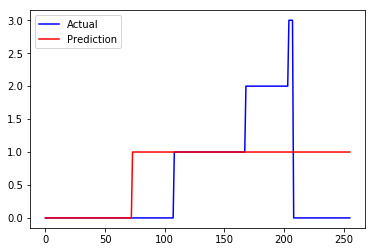

In [31]:
i = 45
plt.plot(y_test_data[i,:],'b')
plt.plot(np.rint(predictions[i][:]),'r')
plt.legend(('Actual','Prediction'))

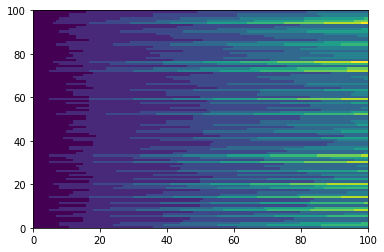

In [41]:
plt.pcolor(y_test_data)

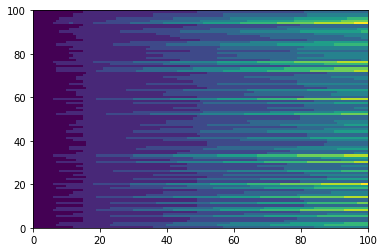

In [42]:
plt.pcolor(np.rint(predictions))

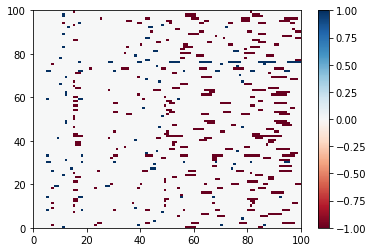

In [43]:
diff = y_test_data- np.rint(predictions)
plt.pcolor(diff,cmap='RdBu')
plt.colorbar()

In [44]:
len(prediction_frames)

15

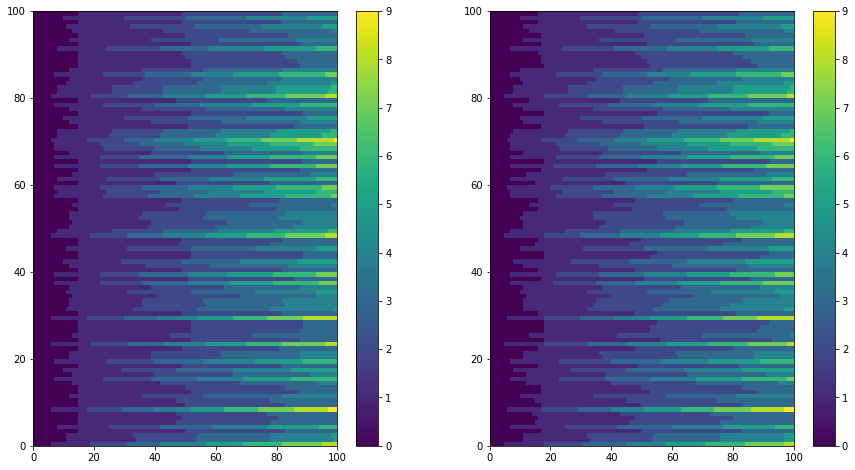

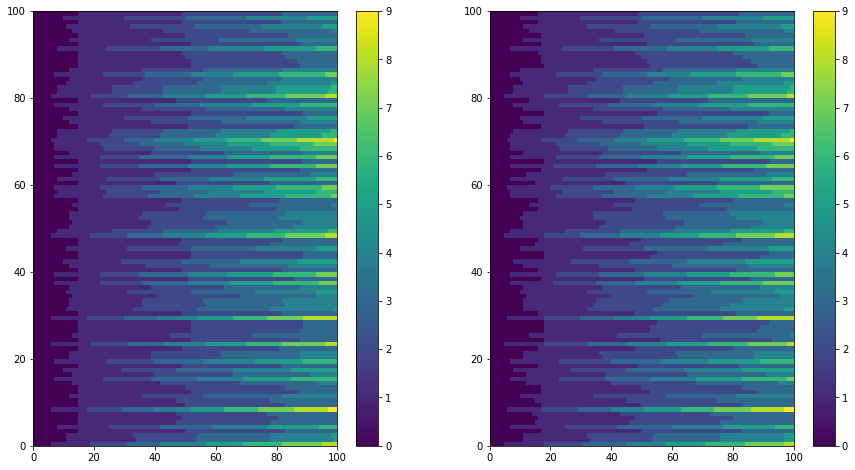

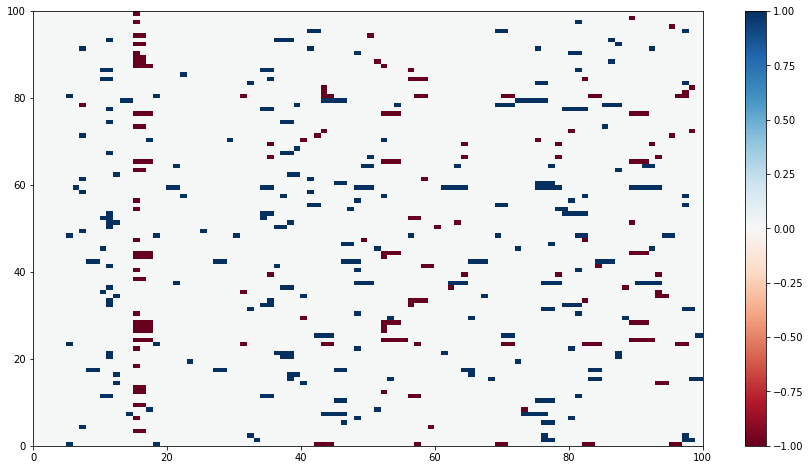

In [12]:
from IPython import display
%matplotlib inline
fig_size = [0,0]
fig_size[0] = 15
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

prediction_frames = np.rint(prediction_frames)
plt.subplot(1,2,2)
plt.pcolor(y_test_data,vmin=0,vmax=9)
plt.colorbar()
plt.subplot(1,2,1)
plt.pcolor(prediction_frames[0],vmin=0,vmax=9)
plt.colorbar()
for i in range(len(prediction_frames)):
    plt.subplot(1,2,1)
    plt.pcolor(prediction_frames[i],vmin = 0,vmax=9)
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(0.1)

plt.figure(2)
diff = y_test_data- np.rint(predictions)
plt.pcolor(diff,cmap='RdBu')
plt.colorbar()

In [31]:
# animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
plt.rcParams['animation.ffmpeg_path'] ='/usr/local/bin/ffmpeg'
%matplotlib 

fig, ax = plt.subplots(1,2)
XX,YY = np.meshgrid(np.linspace(250e-3,300e-3,n_inp),np.arange(100))

def animate(i):
    line = ax[0].pcolor(XX,YY,prediction_frames[i],vmin=0,vmax=9)
    ax[0].set_title(r'Predicted $n_{iter} = $' + str(i*500))
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line = ax[0].pcolor(XX,YY,prediction_frames[0],vmin=0,vmax=9)
    cbar_0 = plt.colorbar(line,ax=ax[0])
    ax[0].set_xlabel(r'$V_{dot} (V)$',fontsize=16)
    ax[0].set_ylabel('Sample Index',fontsize=16)
    ax[0].set_title(r'Expected $n_{iter} = $' + str(0))
    ax[0].set_title('Predicted')
    cbar_0.set_label('Charge State')
    
    
    line2 = ax[1].pcolor(XX,YY,y_test_data)
    cbar_1 = plt.colorbar(line2,ax=ax[1],cmap=my_cmap,ticks=[0,1,2,3])
    cbar_1.set_ticklabels(["QPC","SingleDot","DoubleDot","ShortCircuit"])
    cbar_1.set_ticks([0.5,1.5,2.5,3.5])
    ax[1].set_xlabel(r'$V_{dot} (V)$',fontsize=16)
    ax[1].set_ylabel('Sample Index',fontsize=16)  
    ax[1].set_title('Expected')
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(40) , init_func=init,
                              interval=500, blit=True)

mywriter = animation.FFMpegWriter()
ani.save('mymovie.mp4',writer=mywriter)

plt.show()

Using matplotlib backend: MacOSX
